In [71]:
from skimage import io, measure, morphology, graph, color
import numpy as np
import matplotlib.pyplot as plt

image_path = "/Users/ericayliu/Bowling Lab/250428_gastruloids_mCherry_puro_250507_120h_004_ch00.tiff"
binary = io.imread(image_path)

def get_contour_from_mask(mask, padding=100, smooth=False, smooth_sigma=5):

    # 1. Find contours
    contours = measure.find_contours(mask.astype(float), level=0.5)
    if not contours:
        raise ValueError("No contours found in the binary mask.")
    
    # 2. Use the longest contour
    contour = max(contours, key=len)
    contour = np.array(contour)  # shape (N, 2) — (row, col)

    # 3. Bounding box with padding
    rows, cols = contour[:, 0], contour[:, 1]
    top = max(int(np.min(rows)) - padding, 0)
    bottom = int(np.max(rows)) + padding
    left = max(int(np.min(cols)) - padding, 0)
    right = int(np.max(cols)) + padding
    bbox = [top, bottom, left, right]

    return contour, bbox

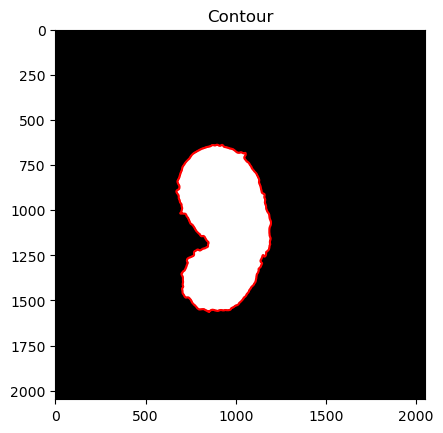

In [73]:
# binary = your 2D mask (e.g., from imu.clean_binarized)
contour, BBOX = get_contour_from_mask(binary, padding=100)

# Plot
plt.imshow(binary, cmap='gray')
plt.plot(contour[:, 1], contour[:, 0], color='red')
plt.title("Contour")
plt.show()

In [51]:
from skimage.morphology import medial_axis
from scipy.spatial.distance import euclidean
from skimage.graph import route_through_array
import numpy as np

def get_axis_and_length(cnt, image):
    """
    Given a contour and the original image, compute:
    - the medial axis skeleton
    - extend it to connect endpoints
    - return the axis coordinates and the midline length in pixels
    """
    # Step 1: Convert contour into binary mask
    from skimage.draw import polygon2mask
    mask = polygon2mask(image.shape, cnt)

    # Step 2: Compute medial axis
    skeleton = medial_axis(mask)

    # Step 3: Extract skeleton coordinates
    coords = np.column_stack(np.nonzero(skeleton))

    if len(coords) < 2:
        raise ValueError("Skeleton too small or disconnected.")

    # Step 4: Find two endpoints (farthest apart on skeleton)
    def farthest_pair(points):
        max_dist = 0
        pair = (points[0], points[1])
        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                d = euclidean(points[i], points[j])
                if d > max_dist:
                    max_dist = d
                    pair = (points[i], points[j])
        return pair

    start, end = farthest_pair(coords)

    # Step 5: Route midline path along skeleton from start to end
    cost_array = np.where(skeleton, 1, np.inf)
    path, _ = route_through_array(cost_array, tuple(start), tuple(end), fully_connected=True)
    MedialAxis = np.array(path)
    
    # Step 6: Compute total midline length
    diffs = np.diff(MedialAxis, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)
    length = segment_lengths.sum()

    return MedialAxis, length


In [53]:
from skimage import measure

# mask: binary mask of the gastruloid (2D numpy array)
# Usually obtained from imu.clean_binarized or manually created

contours = measure.find_contours(mask.astype(float), level=0.5)

# Get the longest one (likely the outer boundary)
cnt = max(contours, key=len)
cnt = np.asarray(cnt)

Length = 568.8338992460372 µm


(-0.5, 2047.5, 2047.5, -0.5)

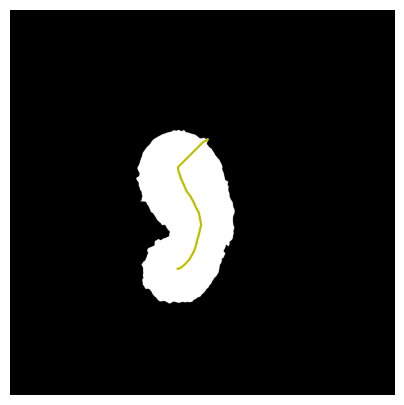

In [61]:
um_per_pixel = 0.65  # or your actual image scale

MedialAxis, length = get_axis_and_length(cnt, binary)

print("Length =", length * um_per_pixel, "µm")

# Visualization
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(binary, cmap='gray')
xM, yM = MedialAxis.T
ax.plot(yM, xM, c='y')
ax.axis('off')
